# Eesmärk
Luua funktsioon *getCommand(image)*.
Funktsioon võtab ette pildifaili ja tagastab enumi pildil olevast käsust näiteks sõnena.   
Funktsioonile tuleb lisada ka tõenäoliselt parameeter *mudel* või mingi muu lahendus teha nii, et funktsioon ise mudelit ei valmista. Mudel peaks olema valmis juba enne ja mängu ajal peaks see funktsioon tagastama vastuse kiiresti (alla 1 sekundi kindlasti). Muidu lihtsalt mäng hakkab hakkima.

### Version 1.1 - Katame mängu tegevuse käskudega
Mängu ajal peab olema võimalik kasutada kolme käsku: vasakule, paremale ja power.
Võimalikud tagastusväärtused funktsioonile *getCommand(image)*:


*   "vasak"
*   "parem"
*   "power"
*   "undefined"

### Version 1.2 - Katame ka mängus navigeerimise käskudega
Edasiarendusena võime katta ka mängus navigeerimise nupud käskudega.





In [72]:
#Moodulite installimine
import numpy as np
import os 
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 

from random import randint
import keras
from keras.utils import to_categorical
from keras import layers
from keras import models
from sklearn.model_selection import train_test_split

## Eeltöötlus

Kasutusel on Kaggelist alla laetud žestide andmestik, mis on leitav siin: https://www.kaggle.com/gti-upm/leapgestrecog
Mängu juhtimiseks on vaja kasutada kolme käsku: vasakule, paremale ja power. Antud andmestik sisaldab 10 erinevat žesti ning otsustasime filtreerida välja vaid vajaminevad:
* "palm" - paremale liikumine
* "ok" - vasakule liikumine
* "c" - power
* "palm_moved"
* "fist"

In [73]:
# Loome sõnastiku, kus hoimae andmeid
lookup = dict()
reverselookup = dict()
count = 0

# Kuna kõik pildid on salvestatud kaustadesse, siis loeme need sisse, ning lisame, mitmendad nad meie järjendis on
for j in os.listdir('leapgestrecog/leapGestRecog/00/'):
    if not j.startswith('.'): # Kuna jooksutame koodi lokaalselt, siis ei taha me sisse lugeda peidetudi kausti 
        lookup[j] = count
        reverselookup[count] = j
        count = count + 1
lookup #prindime välja meie järjendi, kus hoidlustame andmeid

{'01_palm': 0, '02_fist': 1, '03_thumb': 2, '04_c': 3}

In [75]:
# Kogume andmed
x_data = [] # Pilt
y_data = [] # Mis klassi pilt kuulub
datacount = 0 # Loendame kokku, mitu pilti on meie andmestikus

for i in range(0, 10): # Käime läbi kõik 10 kausta, kus pildid asuvad
    for j in os.listdir('leapgestrecog/leapGestRecog/0' + str(i) + '/'): # Võtame vastava kausta
        if not j.startswith('.'): # Väldime lokaalseid peidetuid kausti
            count = 0 # Loendame kokku kaustas asuvad pildid
            for k in os.listdir('leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/'): # Käime kõik pildid läbi                            
                # Avame pildi ja viime vastavale kujule: 'grayscale' + mõõtmed
                img = Image.open('leapgestrecog/leapGestRecog/0' + str(i) + '/' + j + '/' + k).convert('L')
                img = img.resize((320, 120))
                
                # Viime pildi järjendi kujule ning lisame selle x_data järjendisse
                arr = np.array(img)
                x_data.append(arr) 
                count = count + 1 # Suurendame loendajat
            # Lisame vastava klassi
            y_values = np.full((count, 1), lookup[j]) 
            y_data.append(y_values)
            datacount = datacount + count
            
# Viime õigele kujule           
x_data = np.array(x_data, dtype = 'float32')
y_data = np.array(y_data)
y_data = y_data.reshape(datacount, 1)


In [76]:
# Prindime välja järjendite kuju
print(y_data.shape)
print(x_data.shape)

(8000, 1)
(8000, 120, 320)


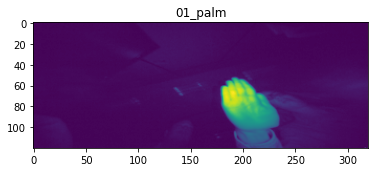

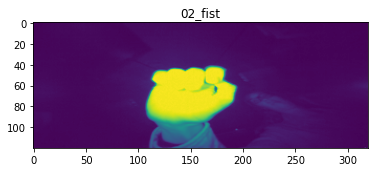

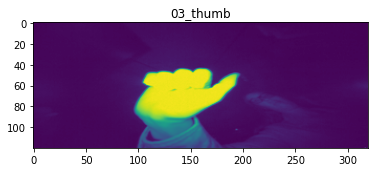

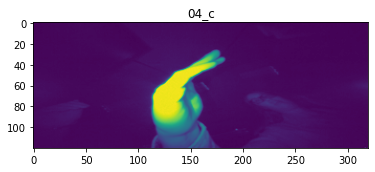

In [77]:
# Andmete visualiseerimiseks prindime suvaliselt välja iga klassi esindaja

for i in range(0, 4):
    plt.imshow(x_data[i*200 , :, :])
    plt.title(reverselookup[y_data[i*200 ,0]])
    plt.show()

In [78]:
# Kuna ennustame 4 kategooria vahel, viime y andmed õigele kujule
y_data = to_categorical(y_data)
x_data = x_data.reshape((datacount, 120, 320, 1))
x_data /= 255

# Jagame andmed treenimiseks ja valideerimiseks
x_train,x_further,y_train,y_further = train_test_split(x_data,y_data,test_size = 0.2)
x_validate,x_test,y_validate,y_test = train_test_split(x_further,y_further,test_size = 0.5)


In [79]:
# Loome mudeli

model=models.Sequential()
model.add(layers.Conv2D(32, (5, 5), strides=(2, 2), activation='relu', input_shape=(120, 320, 1))) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(4, activation='softmax'))



In [80]:
# Treenime loodud mudeli
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, validation_data=(x_validate, y_validate))


Epoch 1/10
100/100 [==============================] - 75s 737ms/step - loss: 0.6142 - accuracy: 0.7433 - val_loss: 0.0172 - val_accuracy: 0.9962
Epoch 2/10
100/100 [==============================] - 74s 743ms/step - loss: 0.0407 - accuracy: 0.9908 - val_loss: 0.0120 - val_accuracy: 0.9975
Epoch 3/10
100/100 [==============================] - 74s 740ms/step - loss: 0.0055 - accuracy: 0.9985 - val_loss: 0.0100 - val_accuracy: 0.9975
Epoch 4/10
100/100 [==============================] - 74s 740ms/step - loss: 0.0059 - accuracy: 0.9978 - val_loss: 0.0138 - val_accuracy: 0.9950
Epoch 5/10
100/100 [==============================] - 72s 724ms/step - loss: 3.9042e-04 - accuracy: 0.9998 - val_loss: 0.0131 - val_accuracy: 0.9962
Epoch 6/10
100/100 [==============================] - 72s 716ms/step - loss: 2.2003e-05 - accuracy: 1.0000 - val_loss: 0.0131 - val_accuracy: 0.9975
Epoch 7/10
100/100 [==============================] - 72s 719ms/step - loss: 8.2614e-08 - accuracy: 1.0000 - val_loss: 0.0

In [81]:
[loss, acc] = model.evaluate(x_test,y_test,verbose=1)
print("Accuracy:" + str(acc))

25/25 [==============================] - 3s 94ms/step - loss: 0.0127 - accuracy: 0.9987
Accuracy:0.9987499713897705


In [84]:
# Enne jooksutamist kustuta nn mudel
model.save("nn")

INFO:tensorflow:Assets written to: nn\assets


In [83]:
#modeln = keras.models.load_model("nn")

#img = Image.open('leapgestrecog/leapGestRecog/02/03_fist/frame_02_03_0003.png').convert('L')
#img = img.resize((320, 120))
#arr = np.array(img, dtype='float32')
#arr = arr.reshape((1, 120, 320, 1))
#print(modeln.predict(arr))